In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files #Wrzucenie pliku csv do colaba
uploaded = files.upload()      # otwierajac normalnie plik .py nie trzeba wywolywac

Saving winequality-red.csv to winequality-red.csv


In [ ]:
wine = pd.read_csv("./winequality-red.csv" , sep=";" ) #wczytanie bazy win czerwonych
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
#Sprawdzając poprawność danych, nie zauważyłem żadnych braków bądź niepoprawności. Jedyną rzeczą na która zwróciłem uwagę, 
#były rozwinięcia okresowe w alcoholu. Postanowiłem zaokrąglić je do 4 miejsc po przecinku.
wine['alcohol'] = round(wine["alcohol"], 4)

In [ ]:
#Wybór predyktorów
x = wine[["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]]
#oraz zmiennej celu
y = wine[['quality']]

In [ ]:
#Podział danych na zbiór uczący oraz testowy 70/30 z indeksem jako ziarno generatora liczb pseudolosowych
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=300136, stratify=y)

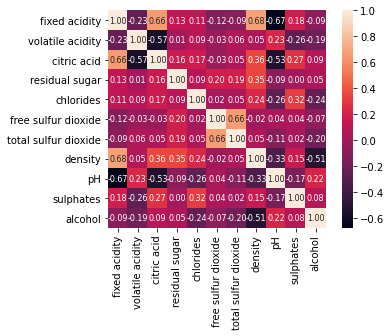

In [ ]:
#Stworzenie macierzy korelacji w celu zbadania powiazań miedzy zmiennymi
cols = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]
cm = np.corrcoef(x_train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols, xticklabels=cols)
plt.show()
#mozemy zauwazyć, że zmienne nie są ze soba skorelowane, dlatego też jako predyktorów w modelu użyjemy wszyskich.
#na tym etapie wydaje mi się, że wszystkie zmienne wpływają w podobnym stopniu na jakość wina. Żadna z nich nie wyróżnia się
#natomiast po zaczerpnieciu informacji z internetu, wiem że do klasyfikacji win na wytrawne, półwytrawne, półsłodkie i słodkie
#znaczenie będą miały zmienne takie jak zawartość alkoholu, cukier, kwasowosc ogólna (PH), kwasowość lotna

In [ ]:
###########################################
#                   KNN                   #
###########################################

In [ ]:
#Problem klasyfikacji postanowiłem rozwiązać algorytmem KNN
#Dokonujemy standaryzacji naszych predyktorow
x_train_stand = stats.zscore(x_train)
x_test_stand = stats.zscore(x_test)

In [ ]:
#a nastepnie uruchamiamy algorytm KNN dla: k=4 używając metryki euklidesowej.
knn = KNeighborsClassifier(4, weights='uniform', metric='euclidean')
knn.fit(x_train_stand, y_train["quality"])
y_predict=knn.predict(x_test_stand)

In [ ]:
set(wine["quality"])
#Mozemy tutaj zauwazyć, że nasze wina przyjmują jedynie oceny jakości z przedziału 3-8 (nie 1-10)

{3, 4, 5, 6, 7, 8}

In [ ]:
#Tworzymy macierz pomyłek
conf_matrix=confusion_matrix(y_test,y_predict)
summ = 0
fullSumm = 0
for i in range(6):
    for j in  range(6):
        if(i == j):
            summ += conf_matrix[i][j]
        fullSumm += conf_matrix[i][j]

print(conf_matrix)
print()
print("Trafność: " + str(summ) + "/" +str(fullSumm)+ " = " + str(summ/fullSumm))

[[  0   1   1   1   0   0]
 [  0   1  12   3   0   0]
 [  0   4 150  48   2   0]
 [  0   2  70 101  18   1]
 [  0   0   6  31  21   2]
 [  0   0   0   2   3   0]]

Trafność: 273/480 = 0.56875


In [ ]:
#Tworzymy macierz pomyłek z odstepstwem o jeden
summ = 0
fullSumm = 0
for i in range(6):
    for j in  range(6):
        if(i == j or (i-1 == j and i > 0) or (i+1 == j and j < 6)):
            summ += conf_matrix[i][j]
        fullSumm += conf_matrix[i][j]

print(conf_matrix)
print()
print("Trafność z odstepstwem o 1: " + str(summ) + "/" +str(fullSumm)+ " = " + str(summ/fullSumm))

[[  0   1   1   1   0   0]
 [  0   1  12   3   0   0]
 [  0   4 150  48   2   0]
 [  0   2  70 101  18   1]
 [  0   0   6  31  21   2]
 [  0   0   0   2   3   0]]

Trafność z odstepstwem o 1: 462/480 = 0.9625


In [ ]:
print('MAE: ',mean_absolute_error(y_test, y_predict))

MAE:  0.4708333333333333


In [ ]:
###########################################
#                   MLP                   #
###########################################

In [ ]:
#Problem szacowania postanowilem rozwiazac poprzez MLP
#Standaryzacja Min-Max dla MLP
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_stand_mlp = scaler.transform(x_train)
x_test_stand_mlp = scaler.transform(x_test)

scaler2 = MinMaxScaler()
scaler2.fit(pd.DataFrame(y_train))
y_train_stand_mlp = scaler2.transform(pd.DataFrame(y_train))
y_test_stand_mlp = scaler2.transform(pd.DataFrame(y_test))

In [ ]:
#Budowa sieci 
siec_neur = MLPRegressor(hidden_layer_sizes=(8,), activation='tanh',solver='lbfgs', alpha=0.0001, max_iter=10000, random_state=300136)
#Uczenie jej
siec_train=siec_neur.fit(x_train_stand_mlp, y_train_stand_mlp.ravel())
#Przewidywanie wartości 
y_predict_mlp = siec_neur.predict(x_test_stand_mlp) 

In [ ]:
#Dokonujemy denormalizacji zmiennych
y_predict_denorm = np.zeros(y_predict_mlp.shape[0]) 
maximum = max(pd.DataFrame(y_test)["quality"])
minimum = min(pd.DataFrame(y_test)["quality"])

i=0
while i<= (y_predict_mlp.shape[0]-1):
      y_predict_denorm[i] = (y_predict_mlp[i]*(maximum-minimum)) + minimum
      i+=1

In [ ]:
y_predict_denorm_round = np.round(y_predict_denorm)

conf_matrix_mlp = confusion_matrix(y_test, y_predict_denorm_round)
summ = 0
fullSumm = 0
for i in range(6):
    for j in  range(6):
        if(i == j):
            summ += conf_matrix_mlp[i][j]
        fullSumm += conf_matrix_mlp[i][j]

print(conf_matrix_mlp)
print()
print("Trafność : " + str(summ) + "/" +str(fullSumm)+ " = " + str(summ/fullSumm))

[[  0   0   3   0   0   0]
 [  1   0  10   5   0   0]
 [  0   4 141  56   3   0]
 [  0   2  55 124  11   0]
 [  0   0   1  39  20   0]
 [  0   0   0   1   4   0]]

Trafność : 285/480 = 0.59375


In [ ]:
summ = 0
fullSumm = 0
for i in range(6):
    for j in  range(6):
        if(i == j or (i-1 == j and i > 0) or (i+1 == j and j < 6)):
            summ += conf_matrix_mlp[i][j]
        fullSumm += conf_matrix_mlp[i][j]

print(conf_matrix_mlp)
print()
print("Trafność z odstepstwem o 1: " + str(summ) + "/" +str(fullSumm)+ " = " + str(summ/fullSumm))

[[  0   0   3   0   0   0]
 [  1   0  10   5   0   0]
 [  0   4 141  56   3   0]
 [  0   2  55 124  11   0]
 [  0   0   1  39  20   0]
 [  0   0   0   1   4   0]]

Trafność z odstepstwem o 1: 465/480 = 0.96875


In [ ]:
print('MAE: ',mean_absolute_error(y_test, y_predict_denorm_round))

MAE:  0.4375


In [ ]:
###########################################
#           Algorytm Centroidów           #
#               K-Średnich                #
###########################################

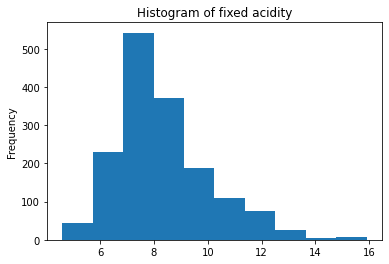

In [ ]:
#ax = sns.boxplot(data=wine['fixed acidity']) #wykres skrzynkowy
wine['fixed acidity'].plot(kind='hist', title='Histogram of fixed acidity') #histogram
#histogram prawostronnie skosny, delikatnie przypomina rozkład normalny.

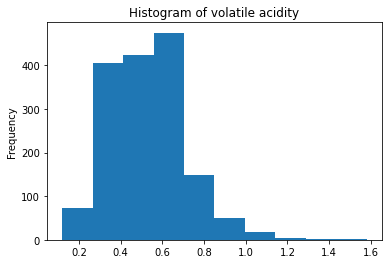

In [ ]:
wine['volatile acidity'].plot(kind='hist', title='Histogram of volatile acidity') 
#histogram niesymetryczny

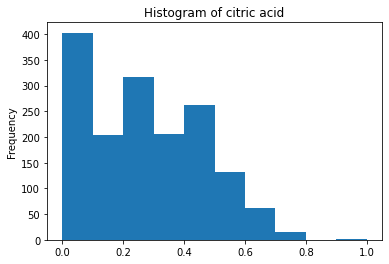

In [ ]:
wine['citric acid'].plot(kind='hist', title='Histogram of citric acid') 
#histogram niesymetryczny

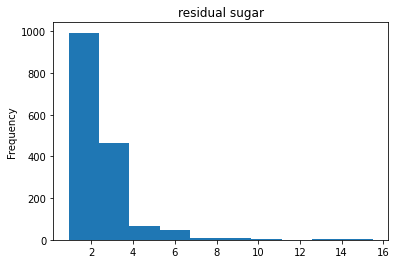

In [ ]:
wine['residual sugar'].plot(kind='hist', title='residual sugar') 
#histogram mocno prawostronnie skośny

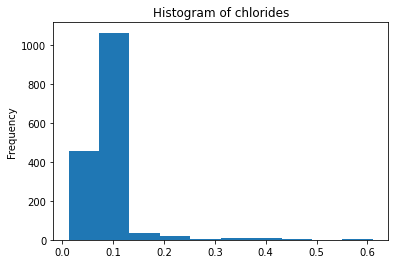

In [ ]:
wine['chlorides'].plot(kind='hist', title='Histogram of chlorides') 
#histogram mocno prawostronnie skośny

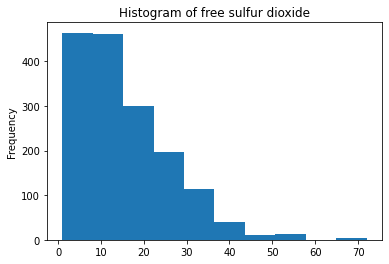

In [ ]:
wine['free sulfur dioxide'].plot(kind='hist', title='Histogram of free sulfur dioxide') 
#histogram niesymetryczny - prawostronnie skośny

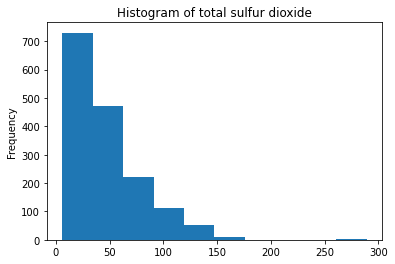

In [ ]:
wine['total sulfur dioxide'].plot(kind='hist', title='Histogram of total sulfur dioxide') 
#histogram niesymetryczny - prawostronnie skośny

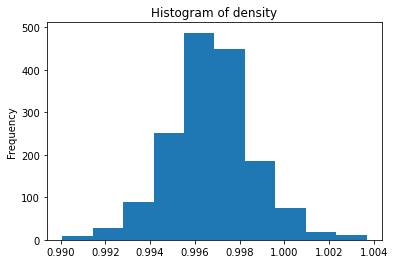

In [ ]:
wine['density'].plot(kind='hist', title='Histogram of density') 
#histogram symetryczny, rozklad zblizony do normalnego

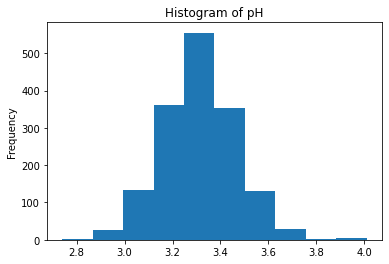

In [ ]:
wine['pH'].plot(kind='hist', title='Histogram of pH') 
#histogram symetryczny, na pierwszy rzut oka wyglada idealnie - rozklad zblizony do normalnego

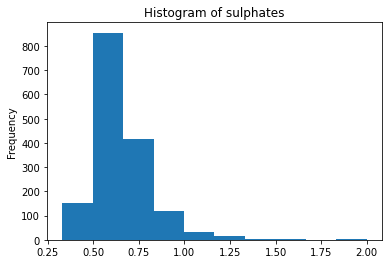

In [ ]:
wine['sulphates'].plot(kind='hist', title='Histogram of sulphates') 
#histogram niesymetryczny - prawostronnie skośny

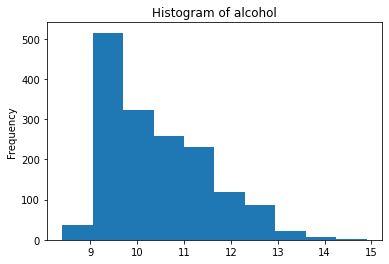

In [ ]:
wine['alcohol'].plot(kind='hist', title='Histogram of alcohol') 
#histogram niesymetryczny - prawostronnie skośny

In [ ]:
#operacje na zmiennych 
wine_k_means = wine.copy()
wine_k_means[cols]=stats.zscore(np.log(wine_k_means[cols]+1))  # ln(x) + 1

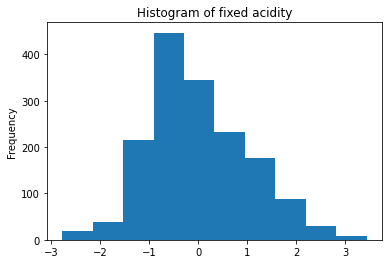

In [ ]:
wine_k_means['fixed acidity'].plot(kind='hist', title='Histogram of fixed acidity') 
#histogram wciąż prawostronnie skosny, bardziej niż poprzedni przypomina rozkład normalny.

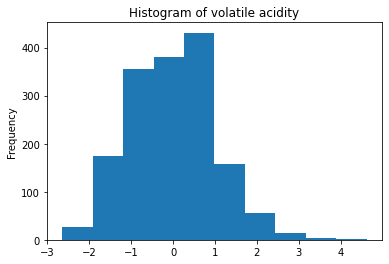

In [ ]:
wine_k_means['volatile acidity'].plot(kind='hist', title='Histogram of volatile acidity')
#histogram wciaz niesymetryczny, aczkolwiek mniej

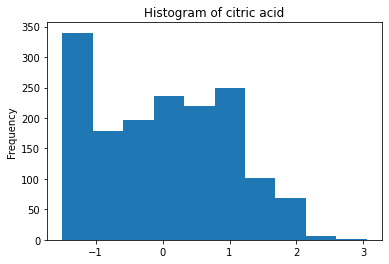

In [ ]:
wine_k_means['citric acid'].plot(kind='hist', title='Histogram of citric acid')
#histogram wciaz niesymetryczny, aczkolwiek mniej - widac poprawe

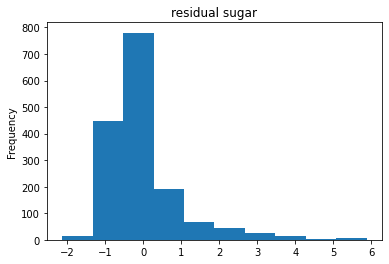

In [ ]:
wine_k_means['residual sugar'].plot(kind='hist', title='residual sugar') 
#histogram wciąż mocno prawostronnie skośny

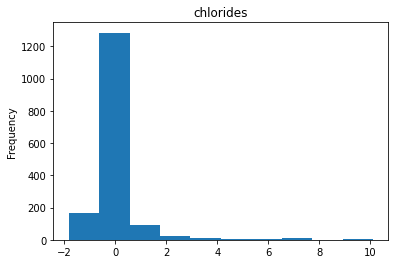

In [ ]:
wine_k_means['chlorides'].plot(kind='hist', title='chlorides') 
#histogram sie poprawil, aczkolwiek delikatnie prawostronnie skosny 

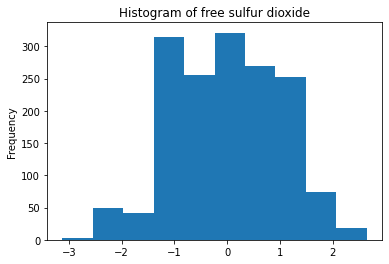

In [ ]:
wine_k_means['free sulfur dioxide'].plot(kind='hist', title='Histogram of free sulfur dioxide') 
#poprawa

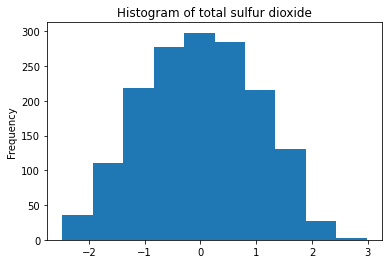

In [ ]:
wine_k_means['total sulfur dioxide'].plot(kind='hist', title='Histogram of total sulfur dioxide') 
#piekna poprawa - histogram niemalże idealny

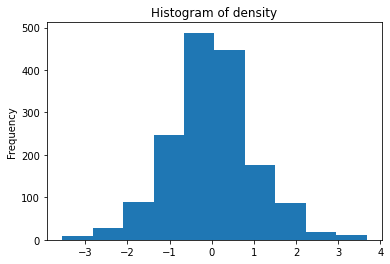

In [ ]:
wine_k_means['density'].plot(kind='hist', title='Histogram of density')
#Ladny histogram zblizony do rozkladu normalnego 

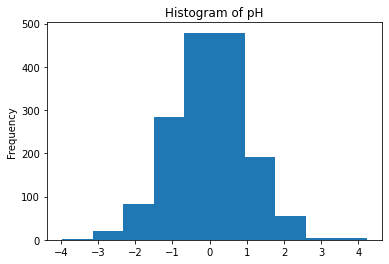

In [ ]:
wine_k_means['pH'].plot(kind='hist', title='Histogram of pH')
#Histogram zblizony do rozkladu normalnego

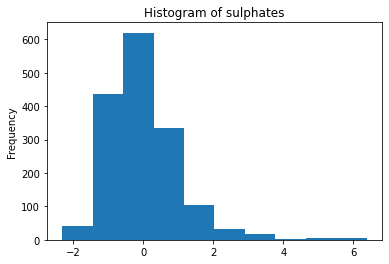

In [ ]:
wine_k_means['sulphates'].plot(kind='hist', title='Histogram of sulphates')
#Wyraźna poprawa, delikatnie prawostronnie skośny

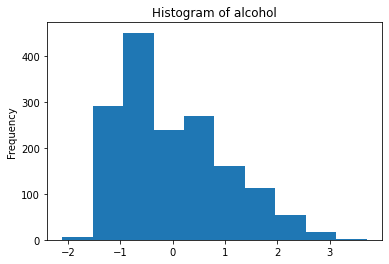

In [ ]:
wine_k_means['alcohol'].plot(kind='hist', title='Histogram of alcohol')
#poprawa - wciaz nie przypomina rozkladu normalnego (prawostronnie skośny)

In [ ]:
#Algorytm K-Średnich dla 3 klastrów z moim indeksem jako ziarno generatora liczb pseudolosowych (przy podziale na 4 klastry jeden jest bardzo nieliczny)
km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=300136)

kmeans=km.fit(wine_k_means[cols])
cluster=kmeans.labels_
Cluster0 = wine_k_means[cols].loc[cluster == 0]
Cluster1 = wine_k_means[cols].loc[cluster == 1]
Cluster2 = wine_k_means[cols].loc[cluster == 2]

opis1 = Cluster0.describe()
opis2 = Cluster1.describe()
opis3 = Cluster2.describe()


In [ ]:
opis1
#Wina wytrawne ze wzgledu na najniższa zawartość tlenków siarki, siarczanów i cukru.
#bardzo liczny - 576 obserwacji
#stała kwasowość poniżej sredniej
#lotna kwasowość powyżej sredniej
#kwas cytrynowy poniżej sredniej
#cukier resztkowy  poniżej sredniej
#chlorki ponizej sredniej
#wolny dwutlenek siarki poniżej sredniej
#całkowity dwutlenek siarki poniżej sredniej
#gęstość poniżej sredniej
#pH powyżej sredniej
#siarczany poniżej sredniej
#alkohol powyżej sredniej

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,-0.764147,0.543017,-0.878656,-0.290831,-0.215961,-0.269841,-0.454336,-0.579722,0.701650,-0.319215,0.193944
std,0.614912,0.904520,0.619745,0.696647,0.550839,0.881336,0.771260,0.843097,0.825302,0.729159,1.039419
min,-2.769397,-2.339214,-1.497274,-1.592065,-1.272557,-2.008867,-2.279303,-3.475170,-1.523412,-2.304047,-1.425495
25%,-1.054196,-0.044068,-1.431973,-0.698491,-0.490632,-0.897333,-1.011650,-1.074275,0.204696,-0.739474,-0.677107
50%,-0.696331,0.514070,-1.053247,-0.442852,-0.251089,-0.247127,-0.391953,-0.527930,0.588773,-0.398482,0.023839
75%,-0.359909,1.013077,-0.466898,-0.089701,-0.061052,0.311420,0.042224,0.012833,1.217410,0.061312,0.864336
max,0.761234,4.618472,1.828842,3.544551,3.940962,2.073160,1.521305,1.405880,4.220567,2.468416,3.059447


In [ ]:
opis2
#PółSlodkie ze wzgledu na wysoka ilosc siarczanu i srednia zawartość cukru.
#rownież liczny zbiór 476 obserwacji
#stała kwasowość  powazej sredniej
#lotna kwasowość poniżej średniej
#kwas cytrynowy powyżej sredniej
#cukier resztkowy poniżej sredniej
#chlorki ponizej poniżej sredniej
#wolny dwutlenek siarki poniżej sredniej
#całkowity dwutlenek siarki poniżej sredniej
#gęstość delikatnie powyżej sredniej
#pH zdecydowanie poniżej sredniej
#siarczany delikatnie powyżej sredniej
#alkohol delikatnie powyżej sredniej

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000
mean,1.025600,-0.694755,1.011611,0.075838,0.300982,-0.595404,-0.558698,0.451202,-0.807030,0.557607,0.285145
std,0.813643,0.768397,0.572000,0.980189,1.585854,0.847812,0.803917,0.997740,0.790849,1.186172,1.015434
min,-1.203981,-2.644648,-0.812386,-1.427358,-1.173503,-3.120402,-2.474994,-1.774859,-3.957395,-1.605257,-2.109913
25%,0.430752,-1.280750,0.663863,-0.568467,-0.394546,-1.111464,-1.090885,-0.236308,-1.250501,-0.265079,-0.472264
50%,1.022518,-0.764808,1.075599,-0.203719,-0.132151,-0.708455,-0.609463,0.359942,-0.779221,0.378016,0.216213
75%,1.604062,-0.218735,1.336405,0.334222,0.274002,0.000070,0.042224,1.088236,-0.250162,1.043350,1.042747
max,3.434380,1.909687,3.051676,5.873725,10.103357,1.799545,1.883506,3.415415,1.464962,6.377026,3.703973


In [ ]:
opis3 
# Są to wina prawdopodobnie słodkie ze wzgledu na wiekszą zawartość tlenków siarki i delikatnie powyższą zawartość cukrów
# liczny zbiór - 547 obserwacji
#stała kwasowość  poniżej sredniej
#lotna kwasowość delikatnie powyżej średniej
#kwas cytrynowy delikatnie powyżej sredniej
#cukier resztkowy powyżej sredniej
#chlorki ponizej delikatnie poniżej sredniej
#wolny dwutlenek siarki powyżej sredniej
#całkowity dwutlenek siarki powyżej sredniej
#gęstość powyżej sredniej
#pH delikatnie poniżej sredniej
#siarczany lekko poniżej sredniej
#alkohol poniżej sredniej

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,-0.087819,0.032770,0.044934,0.240256,-0.034504,0.802269,0.964602,0.217820,-0.036570,-0.149092,-0.452360
std,0.643203,0.905735,0.728569,1.195646,0.540150,0.674212,0.563775,0.856977,0.760697,0.862432,0.760397
min,-1.846576,-2.339214,-1.497274,-2.135272,-1.824297,-1.358661,-0.443380,-3.544303,-2.857391,-1.833141,-1.992862
25%,-0.559335,-0.640463,-0.383353,-0.442852,-0.298819,0.311420,0.519131,-0.281371,-0.579650,-0.739474,-0.991666
50%,-0.167321,0.127163,0.019454,-0.089701,-0.108429,0.864408,0.940729,0.187727,-0.054317,-0.331572,-0.677107
75%,0.373730,0.621528,0.520670,0.433035,0.115836,1.274824,1.369920,0.664563,0.461332,0.315422,-0.073618
max,1.873710,3.388483,2.286894,5.851201,4.001636,2.648268,2.982484,3.674262,1.832229,4.931614,2.217009


In [ ]:
#Rysujemy histogramy dla klastrow. Klaster 0.
#Wybieramy te obserwacje zmiennej quality, ktore sa zwiazane z klastrem 0
wine_0=wine['quality'][cluster==0]
# Separujemy wartosci zmiennej quality ze wzgledu na ocene <3-8>
wine_0_3=wine_0[wine_0==3]
wine_0_4=wine_0[wine_0==4]
wine_0_5=wine_0[wine_0==5]
wine_0_6=wine_0[wine_0==6]
wine_0_7=wine_0[wine_0==7]
wine_0_8=wine_0[wine_0==8]

In [ ]:
#Rysujemy histogramy dla klastrow. Klaster 1.
#Wybieramy te obserwacje zmiennej quality, ktore sa zwiazane z klastrem 1.
wine_1=wine['quality'][cluster==1]
# Separujemy wartosci zmiennej quality ze wzgledu na ocene <3-8>
wine_1_3=wine_1[wine_1==3]
wine_1_4=wine_1[wine_1==4]
wine_1_5=wine_1[wine_1==5]
wine_1_6=wine_1[wine_1==6]
wine_1_7=wine_1[wine_1==7]
wine_1_8=wine_1[wine_1==8]

In [ ]:
#Rysujemy histogramy dla klastrow. Klaster 2.
#Wybieramy te obserwacje zmiennej quality, ktore sa zwiazane z klastrem 2.
wine_2=wine['quality'][cluster==2]
# Separujemy wartosci zmiennej quality ze wzgledu na ocene <3-8>
wine_2_3=wine_2[wine_2==3]
wine_2_4=wine_2[wine_2==4]
wine_2_5=wine_2[wine_2==5]
wine_2_6=wine_2[wine_2==6]
wine_2_7=wine_2[wine_2==7]
wine_2_8=wine_2[wine_2==8]

In [ ]:
#Rysujemy histogramy dla klastrow. Klaster 3.
#Wybieramy te obserwacje zmiennej quality, ktore sa zwiazane z klastrem 3.
wine_3=wine['quality'][cluster==3]
# Separujemy wartosci zmiennej quality ze wzgledu na ocene <3-8>
wine_3_3=wine_3[wine_3==3]
wine_3_4=wine_3[wine_3==4]
wine_3_5=wine_3[wine_3==5]
wine_3_6=wine_3[wine_3==6]
wine_3_7=wine_3[wine_3==7]
wine_3_8=wine_3[wine_3==8]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


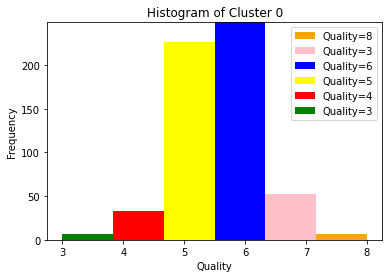

In [ ]:
plt.hist([wine_0_3,wine_0_4,wine_0_5,wine_0_6,wine_0_7,wine_0_8], bins=6, stacked=True, color=['green', 'red', "yellow", "blue", "pink", "orange"], label = ['Quality=3', 'Quality=4','Quality=5','Quality=6','Quality=3','Quality=8' ])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.title('Histogram of Cluster 0')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


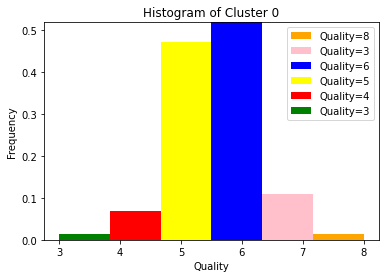

In [ ]:
plt.hist([wine_0_3,wine_0_4,wine_0_5,wine_0_6,wine_0_7,wine_0_8], bins=6, density=True, stacked=True, color=['green', 'red', "yellow", "blue", "pink", "orange"], label = ['Quality=3', 'Quality=4','Quality=5','Quality=6','Quality=3','Quality=8' ])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.title('Histogram of Cluster 0')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


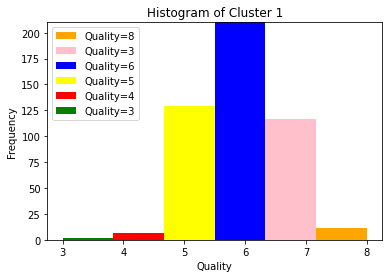

In [ ]:
plt.hist([wine_1_3,wine_1_4,wine_1_5,wine_1_6,wine_1_7,wine_1_8], bins=6, stacked=True, color=['green', 'red', "yellow", "blue", "pink", "orange"], label = ['Quality=3', 'Quality=4','Quality=5','Quality=6','Quality=3','Quality=8' ])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.title('Histogram of Cluster 1')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


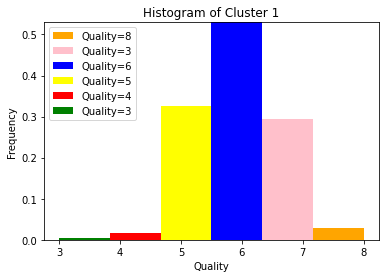

In [ ]:
plt.hist([wine_1_3,wine_1_4,wine_1_5,wine_1_6,wine_1_7,wine_1_8], bins=6, density = True, stacked=True, color=['green', 'red', "yellow", "blue", "pink", "orange"], label = ['Quality=3', 'Quality=4','Quality=5','Quality=6','Quality=3','Quality=8' ])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.title('Histogram of Cluster 1')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


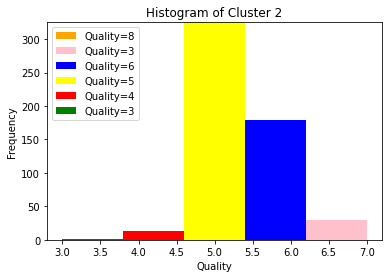

In [ ]:
plt.hist([wine_2_3,wine_2_4,wine_2_5,wine_2_6,wine_2_7,wine_2_8], bins=5, stacked=True, color=['green', 'red', "yellow", "blue", "pink", "orange"], label = ['Quality=3', 'Quality=4','Quality=5','Quality=6','Quality=3','Quality=8' ])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.title('Histogram of Cluster 2')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


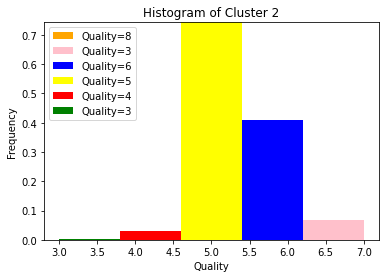

In [ ]:
plt.hist([wine_2_3,wine_2_4,wine_2_5,wine_2_6,wine_2_7,wine_2_8], bins=5, density=True ,stacked=True, color=['green', 'red', "yellow", "blue", "pink", "orange"], label = ['Quality=3', 'Quality=4','Quality=5','Quality=6','Quality=3','Quality=8' ])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.title('Histogram of Cluster 2')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()